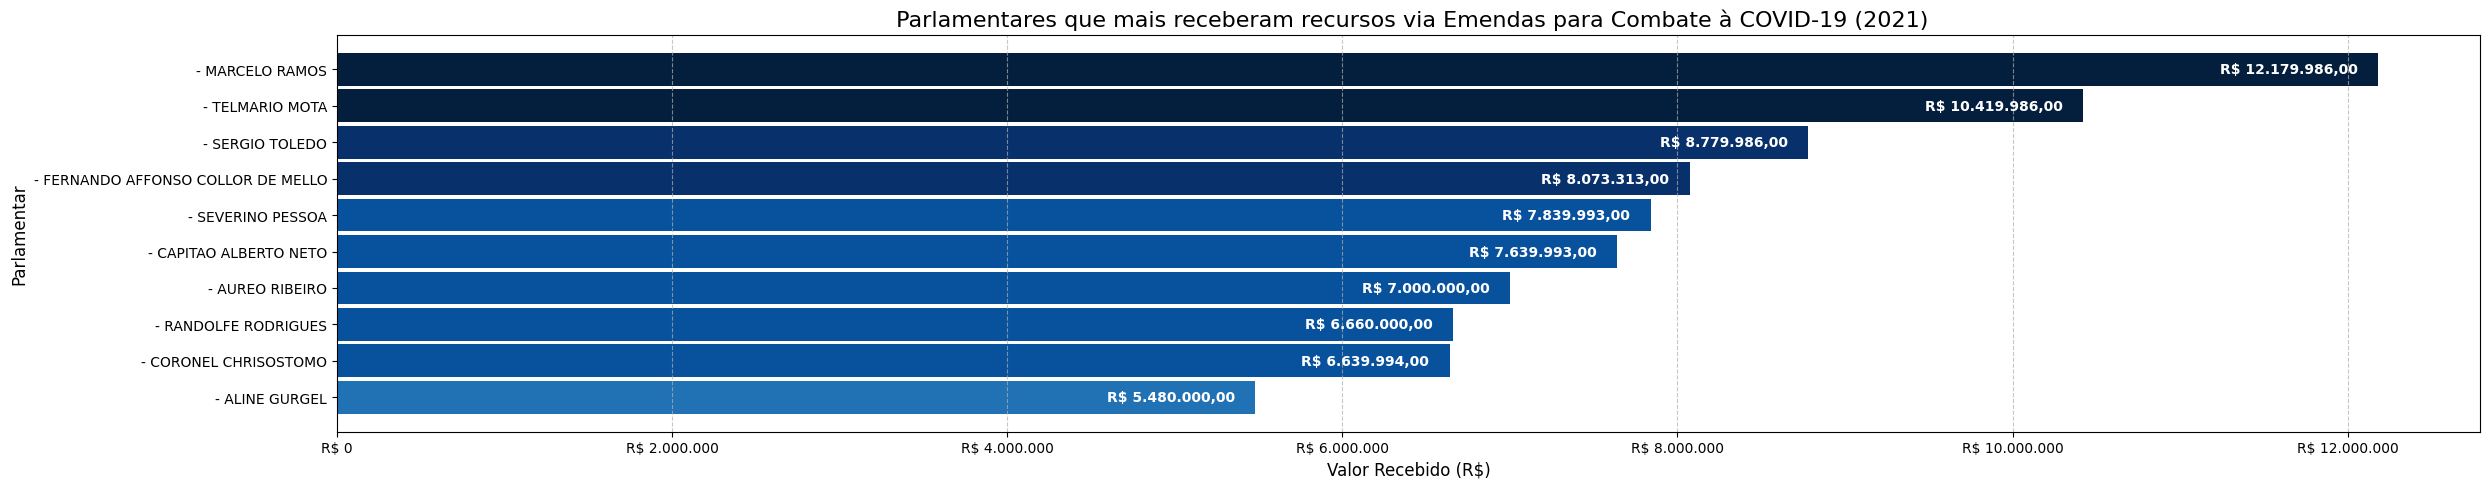

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import unidecode

# 1. Carregar os dados
df = pd.read_csv(
    "/home/nandowsl/git/projetosNandoJava/ProjetoAnaliseDeDadosPython/CovidNoBrasil/dados/despesas_coronavirus.csv",
    sep=';',
    encoding='utf-8'
)

# 2. Limpeza e normalização
df = df[df["Ação Orçamentária"].notna()]
df = df[df["Autor Emenda"].notna() & (df["Autor Emenda"] != "0000")]
df = df[~df["Autor Emenda"].str.contains("BANCADA", case=False, na=False)]
df = df[df["Valor Pago"].notna()]

# 3. Limpeza da coluna "Valor Pago"
df["Valor Pago"] = df["Valor Pago"].astype(str)
df["Valor Pago"] = df["Valor Pago"].str.replace(".", "", regex=False)
df["Valor Pago"] = df["Valor Pago"].str.replace(",", ".", regex=False)
df["Valor Pago"] = pd.to_numeric(df["Valor Pago"], errors="coerce")

# 4. Normalizar ação para facilitar o filtro
df["Ação Orçamentária Normalizada"] = df["Ação Orçamentária"].apply(
    lambda x: unidecode.unidecode(str(x)).upper()
)

# 5. Filtrar pelas ações específicas de COVID
filtro1 = "21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA DE IMPORTANCIA INTERNACIONAL DECORRENTE DO CORONAVIRUS"
filtro2 = "2F01 - REFORCO DE RECURSOS PARA EMERGENCIA INTERNACIONAL EM SAUDE PUBLICA - CORONAVIRUS"
df = df[df["Ação Orçamentária Normalizada"].str.contains(filtro1) | df["Ação Orçamentária Normalizada"].str.contains(filtro2)]

# 6. Somar valores pagos por deputado
df_valor_pago = df.groupby("Autor Emenda")["Valor Pago"].sum().reset_index()

# 7. Padronizar nome dos deputados
df_valor_pago["Autor Emenda"] = df_valor_pago["Autor Emenda"].apply(lambda x: " ".join(x.split(" ")[1:]))

# 8. Ordenar pelos que mais receberam
df_valor_pago = df_valor_pago.sort_values("Valor Pago", ascending=False).head(10).iloc[::-1]

# 9. Definir faixas e cores
def get_color(valor):
    if valor == 0:
        return '#d9d9d9'
    elif valor <= 500_000:
        return '#c6dbef'
    elif valor <= 1_000_000:
        return '#9ecae1'
    elif valor <= 2_000_000:
        return '#6baed6'
    elif valor <= 4_000_000:
        return '#4292c6'
    elif valor <= 6_000_000:
        return '#2171b5'
    elif valor <= 8_000_000:
        return '#08519c'
    elif valor <= 10_000_000:
        return '#08306b'
    else:
        return '#041f3d'

colors = df_valor_pago["Valor Pago"].apply(get_color)

# 10. Gráfico
altura = len(df_valor_pago) * 0.5 
fig, ax = plt.subplots(figsize=(25, altura))  # largura 20, altura 10
  # altura dinâmica
bars = ax.barh(df_valor_pago["Autor Emenda"], df_valor_pago["Valor Pago"], color=colors,height=0.9)

# 11. Adiciona os valores dentro das barras
for bar in bars:
    valor = bar.get_width()
    texto = f"R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
    
    ax.text(
        valor - (df_valor_pago["Valor Pago"].max() * 0.01),  # um pouco antes do fim da barra
        bar.get_y() + bar.get_height() / 2,
        texto,
        va='center',
        ha='right',  # texto alinhado à direita (dentro da barra)
        color='white',  # para aparecer sobre a cor da barra
        fontsize=10,
        fontweight='bold'
    )

# 12. Título e eixos
ax.set_title(" Parlamentares que mais receberam recursos via Emendas para Combate à COVID-19 (2021)", fontsize=16)
ax.set_xlabel("Valor Recebido (R$)", fontsize=12)
ax.set_ylabel("Parlamentar", fontsize=12)

# Adiciona o grid horizontal
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

ax.xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'R$ {x:,.0f}'.replace(",", "X").replace(".", ",").replace("X", "."))
)
plt.subplots_adjust(bottom=0.25)

plt.tight_layout()
plt.show()

